# imports

In [1]:
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
import copy
import numpy as np
import os
from display_aux import *
from ships import SHIPS
from df_aux import *
from time_aux import *
from file_aux import *
from plot_aux import *
from parse_aux import *
import sys

In [2]:
%matplotlib ipympl

In [3]:
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', None)


# Run definitions

In [4]:
params = {}
params['input_csv_file_name_full'] = 'C:\\gilad\\work\\tip_and_que\\data\\AIS\\Combined\\Spire_AIS_Combined_All_20231101_1106_000000000000.csv'
# params['input_csv_file_name_full'] = 'debug_data_base.csv'

params['columns_list_keep'] = None
params['filter_vessels_df_dic'] = {
        'max_time_diff[mins]':['<=',30]
        }
params['reload_level'] = 3
params['reload_df_filt'] = False
params['reload_vessels'] = True
params['save_folder_base'] = './pkl'

params['export_to_excel'] = False
params['ana_vessel_name'] = 'EYVAN'
params['ana_vessel_name'] = 'PENG FENG JI'

# params['df_filter_dic'] = {'position_timestamp':['<=','2023-11-01 02:00:00+0000']}
params['df_filter_dic'] = {}

# Load

In [5]:
save_folder = params['save_folder_base']+'/'+ get_file_base_name(params['input_csv_file_name_full'])

ships = SHIPS(save_folder=save_folder)


In [6]:
df = ships.load_raw_data(params['input_csv_file_name_full'],reload_level=params['reload_level'],save_folder=save_folder)

# filter_df
df = ships.prepare_df(df,reload_level=params['reload_level'],df_filter_dic=params['df_filter_dic'],save_folder=save_folder,columns_list_keep=params['columns_list_keep'])

data_dic = ships.create_data_dic(df,reload_level=params['reload_level'],save_folder=save_folder)


load_row_data
----------------
prepare_df
----------------
load df from ./pkl/Spire_AIS_Combined_All_20231101_1106_000000000000/df_filt.pkl
create_data_dic
----------------


In [7]:
display(df.time.min())
display(df.time.max())

Timestamp('2023-11-01 00:00:00+0000', tz='UTC')

Timestamp('2023-11-01 01:27:53+0000', tz='UTC')

Number of common time chunks found: 29


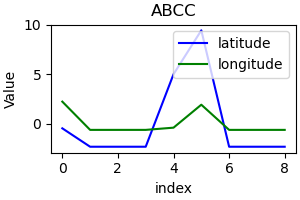

In [8]:
from scipy.signal import find_peaks


ship_df = ships.get_ship_df('ABCC',item_type='name',handle_common_time_rows=True)
ship_df.loc[:,'time_seconds']=ship_df.loc[:,'time_seconds']-ship_df.loc[:,'time_seconds'].min()

ship_df.head()
# display([ship_df['time_seconds']])
ships.plot_ship_data(df,'ABCC',pre_process='remove_bias')

# ship_df = normalize_columns(ship_df,columns=['latitude'],method='min-max')


# x = np.array(ship_df['latitude'])[1:]
# peak_points = find_peaks(x,distance=3)[0]
# plot (x,marker_points=peak_points,line_style='-',marker_style='x',marker_points_style='o')


In [9]:
# example
info_df = ships.create_info_df(num_lines=1000,reload_level=0)
print(len(ships.info_df[ships.info_df['processed']]))
print(len(ships.info_df.columns))
print(ships.info_df.head(10))


create info_df
----------------
processing name 0 out of 10
Number of common time chunks found: 352
Number of common time chunks found: 0
Number of common time chunks found: 0
Number of common time chunks found: 0
Number of common time chunks found: 4
Number of common time chunks found: 1
Number of common time chunks found: 5
Number of common time chunks found: 0
Number of common time chunks found: 9
Number of common time chunks found: 0
save var to ./pkl/Spire_AIS_Combined_All_20231101_1106_000000000000/info_df.pkl
11
15
                      processed                  name    len  \
                           True                        172.0   
) KSV7H 255                True           ) KSV7H 255    1.0   
!!32001-384%               True          !!32001-384%    1.0   
*7904068-4@@@@@@@@@@       True  *7904068-4@@@@@@@@@@   19.0   
**ALI1**                   True              **ALI1**    1.0   
*). 9)168-0180%            True       *). 9)168-0180%    1.0   
ABCC                    

In [10]:
print(len(ships.info_df[ships.info_df['processed']]))
print(len(ships.info_df.columns))


11
15


In [11]:
import pandas as pd



def merge_dataframes(df1, df2, how='left'):
    # Ensure that indices are aligned for merging
    df1 = df1.copy()
    df2 = df2.copy()

    # Merge DataFrames
    merged_df = df1.merge(df2, left_index=True, right_index=True, how=how, suffixes=('', '_dup'))

    # Remove duplicate columns
    cols = merged_df.columns
    for col in cols:
        if '_dup' in col:
            original_col = col.replace('_dup', '')
            if original_col in merged_df.columns:
                # Handle duplication
                merged_df[original_col] = merged_df[[original_col, col]].bfill(axis=1).iloc[:, 0]
                merged_df.drop(columns=[col], inplace=True)

    return merged_df


# Create df1 with 10 rows and a column 'processed'
df1 = pd.DataFrame({
    'processed': [True, False, True, False, True, False, True, False, True, False],
    'index': range(10)
}).set_index('index')


# Create df2 with 5 rows
df2 = pd.DataFrame({
    'index': [0, 1, 2, 3, 4],
    'data': [10, 20, 30, 40, 50],
    'info': ['A', 'B', 'C', 'D', 'E']
}).set_index('index')


# Create df3 with 5 rows
df3 = pd.DataFrame({
    'index': [5, 6, 7, 8, 9],
    'data': [100, 200, 300, 400, 500],
    'info': ['F', 'G', 'H', 'I', 'J']
}).set_index('index')

display(df1)
df1 = merge_dataframes(df1, df2)
display(df1)
df1 = merge_dataframes(df1, df3)
display(df1)


,processed
index,
0,True
1,False
2,True
3,False
4,True
5,False
6,True
7,False
8,True


,processed,data,info
index,,,
0,True,10.0,A
1,False,20.0,B
2,True,30.0,C
3,False,40.0,D
4,True,50.0,E
5,False,NaN,NaN
6,True,NaN,NaN
7,False,NaN,NaN
8,True,NaN,NaN


,processed,data,info
index,,,
0,True,10.0,A
1,False,20.0,B
2,True,30.0,C
3,False,40.0,D
4,True,50.0,E
5,False,100.0,F
6,True,200.0,G
7,False,300.0,H
8,True,400.0,I


In [12]:
len(np.where(info_df['processed']))

1

In [13]:
item_list = list(ships.data_dic.keys())
item_list[:10]

['',
 '!!32001-384%',
 '!!32001-887%',
 '!N33@@@@@@@@@@@@@@@@',
 '"TM DHDL@A&       "',
 '#####@@@@@@@@@@@@@@@',
 ') KSV7H 255',
 '*). 9)168-0180%',
 '**ALI1**',
 '*7904068-4@@@@@@@@@@']

In [14]:
item_type = 'name'
control_item_type = 'mmsi'
info_df = info_df.sort_values(by='span_longitude',ascending=False)

info_df_filter = {'len': ['>',10],
                    f'num_{control_item_type}s':['==',1]}

info_df_filt = filter_df(info_df,info_df_filter)

ship_names = info_df_filt.index[range(1)].tolist()
ylim_val = [-info_df_filt['span_longitude'].max(),info_df_filt['span_longitude'].max()]
ships.plot_ship_data(df,ship_names,columns=['latitude', 'longitude','time_seconds'],sort_columms='time',pre_process='remove_bias')



Error: Column 'num_mmsis' does not exist in the DataFrame. Existing columns: ['processed', 'name', 'len', 'min_time', 'max_time', 'total_time', 'min_time_diff[mins]', 'max_time_diff[mins]', 'mean_time_diff[mins]', 'min_longitude', 'max_longitude', 'min_latitude', 'max_latitude', 'span_longitude', 'span_latitude']


IndexError: index 0 is out of bounds for axis 0 with size 0